# Machine Learning Assignment

## Load all required libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Task 1 -  Model Development and Experiment Design

### Configure MLflow Tracking Server

**IMPORTANT:** Before running the code below, start MLflow server in a terminal:

mlflow server --host 127.0.0.1 --port 5000


In [2]:
# Set MLflow tracking URI
mlflow.set_tracking_uri("http://localhost:5000")

# Set experiment name
mlflow.set_experiment("ML_ASG_bike_sharing_demand_prediction")

print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {mlflow.get_experiment_by_name('ML_bike_sharing_demand_prediction').name}")

2026/02/08 17:06:42 INFO mlflow.tracking.fluent: Experiment with name 'ML_ASG_bike_sharing_demand_prediction' does not exist. Creating a new experiment.


Tracking URI: http://localhost:5000
Experiment: ML_bike_sharing_demand_prediction


### Load & Explore 2011 Data

In [3]:
# Load the 2011 dataset
df_2011 = pd.read_csv('day_2011.csv')

df_2011.shape

(365, 12)

In [4]:
df_2011.head()

,dteday,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01/01/2011,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,02/01/2011,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,03/01/2011,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,04/01/2011,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,05/01/2011,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [5]:
# check distribution of data
df_2011.describe()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2.498630,6.526027,0.027397,3.008219,0.684932,1.421918,0.486665,0.466835,0.643665,0.191403,3405.761644
std,1.110946,3.452584,0.163462,2.006155,0.465181,0.571831,0.189596,0.168836,0.148744,0.076890,1378.753666
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,431.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.325000,0.321954,0.538333,0.135583,2132.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.479167,0.472846,0.647500,0.186900,3740.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.656667,0.612379,0.742083,0.235075,4586.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.849167,0.840896,0.972500,0.507463,6043.000000


In [6]:
df_2011.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      365 non-null    object 
 1   season      365 non-null    int64  
 2   mnth        365 non-null    int64  
 3   holiday     365 non-null    int64  
 4   weekday     365 non-null    int64  
 5   workingday  365 non-null    int64  
 6   weathersit  365 non-null    int64  
 7   temp        365 non-null    float64
 8   atemp       365 non-null    float64
 9   hum         365 non-null    float64
 10  windspeed   365 non-null    float64
 11  cnt         365 non-null    int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 34.3+ KB


In [7]:
# check for missing value 
df_2011.isnull().sum()

dteday        0
season        0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

### Data Preprocessing 

In [8]:
# Make a copy to preserve the original dataframe
df_2011_processed = df_2011.copy()

# Convert dteday to datetime 
df_2011_processed['dteday'] = pd.to_datetime(df_2011_processed['dteday'], dayfirst=True)

# Extract only day and year (since month already exist)
df_2011_processed['day'] = df_2011_processed['dteday'].dt.day
df_2011_processed['year'] = df_2011_processed['dteday'].dt.year

# Drop the original date column
df_2011_processed = df_2011_processed.drop('dteday', axis=1)

df_2011_processed.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day,year
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,1,2011
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,2,2011
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,3,2011
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,4,2011
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,5,2011


In [9]:
num_cols = [c for c in df_2011_processed.columns if df_2011_processed[c].dtypes !='O']

print(num_cols)

['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'day', 'year']


In [10]:
cat_cols = [c for c in df_2011_processed.columns if df_2011_processed[c].dtypes =='O']

print(cat_cols)

[]


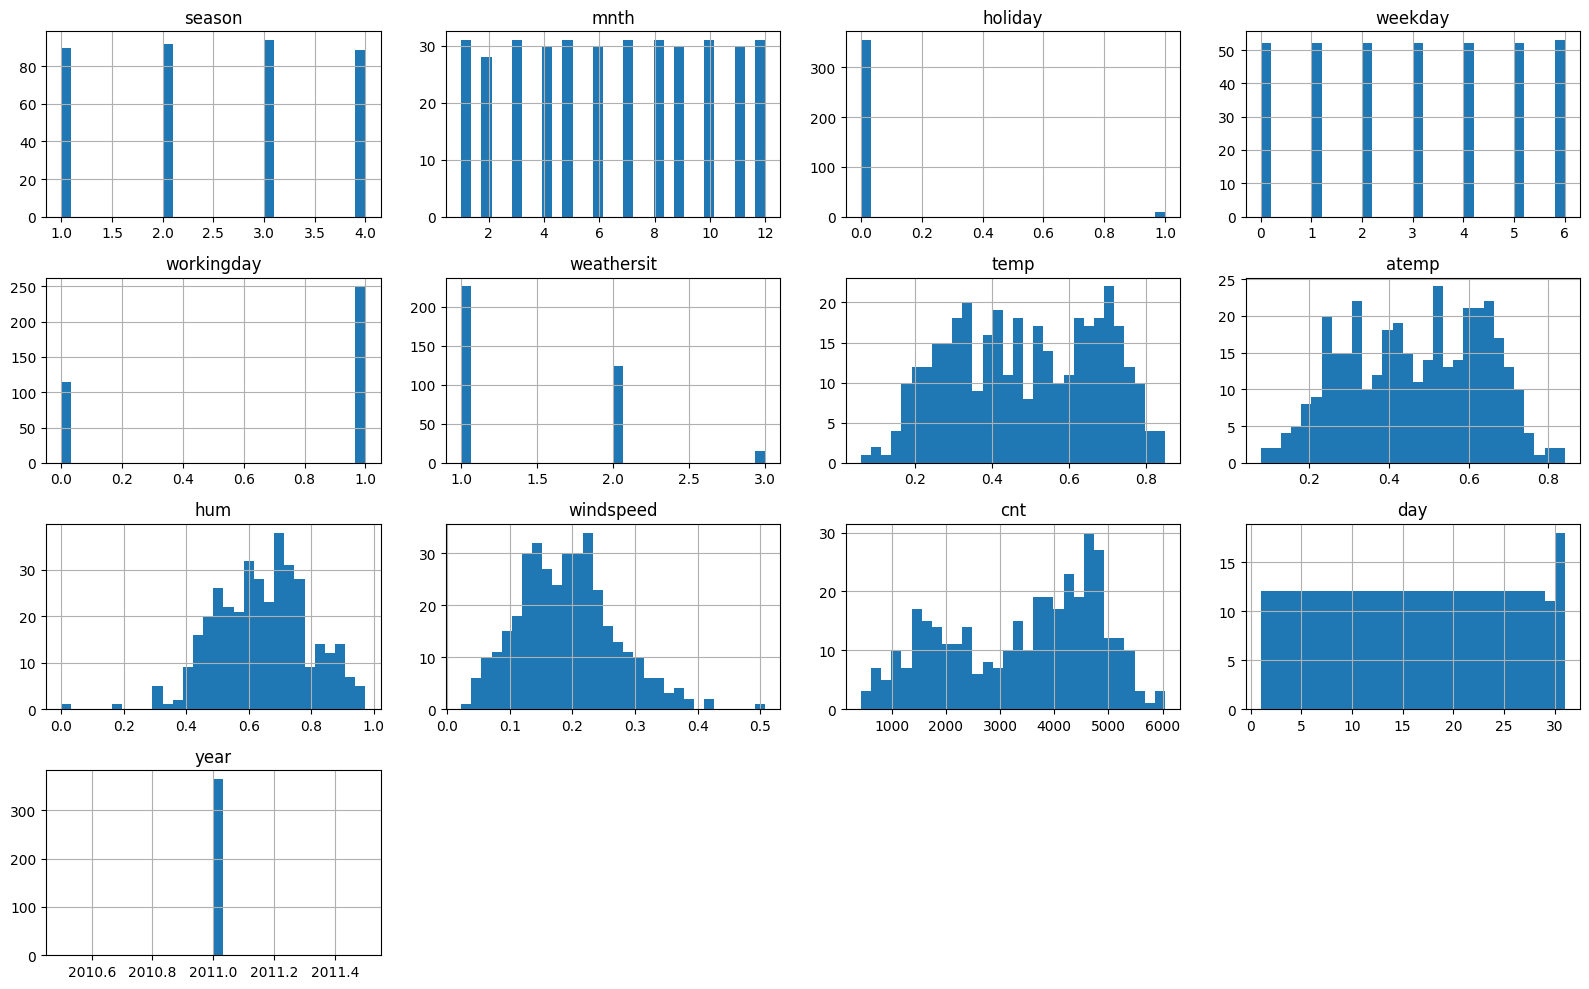

In [11]:
df_2011_processed[num_cols].hist(bins=30, figsize=(16,10))
plt.tight_layout()

In [12]:
df_2011_processed_ohe = pd.get_dummies(df_2011_processed, columns=['season', 'weathersit', 'weekday', 'mnth'], drop_first=True, dtype=int)

df_2011_processed_ohe.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,day,year,season_2,...,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,0,0,0.344167,0.363625,0.805833,0.160446,985,1,2011,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0.363478,0.353739,0.696087,0.248539,801,2,2011,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0.196364,0.189405,0.437273,0.248309,1349,3,2011,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0.200000,0.212122,0.590435,0.160296,1562,4,2011,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0.226957,0.229270,0.436957,0.186900,1600,5,2011,0,...,0,0,0,0,0,0,0,0,0,0


### Prepare Features and Target

In [13]:
# separate features and target
X = df_2011_processed_ohe.drop('cnt', axis=1)
y = df_2011_processed_ohe['cnt']

In [14]:
# Train-test split
X_train_2011, X_test_2011, y_train_2011, y_test_2011 = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_2011.shape, X_test_2011.shape

((292, 30), (73, 30))

### Baseline Model - Linear Regression

In [15]:
with mlflow.start_run(run_name="baseline_linear_regression") as baseline_run:
    
    baseline_run_id = baseline_run.info.run_id
    
    # Tags are searchable labels in MLflow UI
    mlflow.set_tag("model_type", "LinearRegression")
    mlflow.set_tag("role", "baseline")
    mlflow.set_tag("dataset", "day_2011")
    mlflow.set_tag("problem_type", "regression")

    
    lr = LinearRegression()
    lr.fit(X_train_2011, y_train_2011)

    # Predictions
    y_pred_train = lr.predict(X_train_2011)
    y_pred_test  = lr.predict(X_test_2011)

    # Metrics (TRAIN)
    train_rmse = np.sqrt(mean_squared_error(y_train_2011, y_pred_train))
    train_mae  = mean_absolute_error(y_train_2011, y_pred_train)
    train_r2   = r2_score(y_train_2011, y_pred_train)

    # Metrics (TEST)
    test_rmse = np.sqrt(mean_squared_error(y_test_2011, y_pred_test))
    test_mae  = mean_absolute_error(y_test_2011, y_pred_test)
    test_r2   = r2_score(y_test_2011, y_pred_test)

    # Log params + metrics
    params = lr.get_params()
    mlflow.log_params(params)
    mlflow.log_metrics({
        "train_rmse": train_rmse, "train_mae": train_mae, "train_r2": train_r2,
        "test_rmse": test_rmse,   "test_mae": test_mae,   "test_r2": test_r2
    })

    # Infer the model signature
    signature = infer_signature(X_train_2011, lr.predict(X_train_2011))

    
    # Log the model, which inherits the parameters and metric
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="linear_regression",
        signature=signature,
        input_example=X_train_2011.head(5),
        registered_model_name="linear_regression"
    )


print("RUN COMPLETED")
print("Baseline Run ID:", baseline_run_id)
print(f"Train -> RMSE: {train_rmse:.3f} | MAE: {train_mae:.3f} | R2: {train_r2:.3f}")
print(f"Test  -> RMSE: {test_rmse:.3f} | MAE: {test_mae:.3f} | R2: {test_r2:.3f}")

C:\anaconda_envs\ML2\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/02/08 17:06:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Successfully registered model 'linear_regression'.
2026/02/08 17:07:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: linear_regression, version 1
Created version '1' of model 'linear_regression'.


🏃 View run baseline_linear_regression at: http://localhost:5000/#/experiments/10/runs/6ae38f955daa474883c1bc18f86b6793
🧪 View experiment at: http://localhost:5000/#/experiments/10
RUN COMPLETED
Baseline Run ID: 6ae38f955daa474883c1bc18f86b6793
Train -> RMSE: 528.030 | MAE: 396.937 | R2: 0.853
Test  -> RMSE: 648.015 | MAE: 451.145 | R2: 0.775


### Improved Model - Random Forest Regressor

In [16]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING")
print("="*70)


n_estimators_list = [50, 100, 200, 500]
max_depth_list = [3, 5, 10, 20]

best_rmse = float("inf")
best_params = None
best_model = None
best_metrics = None

with mlflow.start_run(run_name="Improved_Random_Forest") as improved_run:
    improved_run_id = improved_run.info.run_id

    mlflow.set_tag("model_type", "RandomForestRegressor")
    mlflow.set_tag("dataset", "day_2011")
    mlflow.set_tag("role", "tuning")
    mlflow.set_tag("problem_type", "regression")

    for n_est in n_estimators_list:
        for max_d in max_depth_list:

            with mlflow.start_run(
                nested=True,
                run_name=f"RF_nest{n_est}_depth{max_d}"
            ):
                params = {
                    "n_estimators": n_est,
                    "max_depth": max_d,
                    "random_state": 42,
                    "n_jobs": -1
                }

                rf = RandomForestRegressor(**params)
                rf.fit(X_train_2011, y_train_2011)

                # Predictions
                y_pred_train = rf.predict(X_train_2011)
                y_pred_test = rf.predict(X_test_2011)

                # Metrics (TRAIN)
                train_rmse = np.sqrt(mean_squared_error(y_train_2011, y_pred_train))
                train_mae = mean_absolute_error(y_train_2011, y_pred_train)
                train_r2 = r2_score(y_train_2011, y_pred_train)

                # Metrics (TEST)
                test_rmse = np.sqrt(mean_squared_error(y_test_2011, y_pred_test))
                test_mae = mean_absolute_error(y_test_2011, y_pred_test)
                test_r2 = r2_score(y_test_2011, y_pred_test)

                # Log params + metrics
                mlflow.log_params(params)
                mlflow.log_metrics({
                    "train_rmse": train_rmse, "train_mae": train_mae, "train_r2": train_r2,
                    "test_rmse": test_rmse,   "test_mae": test_mae,   "test_r2": test_r2
                })

                print(
                    f"\n n_estimators={n_est}, max_depth={max_d} | "
                    f"Test RMSE={test_rmse:.3f}, MAE={test_mae:.3f}, R2={test_r2:.3f}"
                )

                # Track best model (lowest TEST RMSE)
                if test_rmse < best_rmse:
                    best_rmse = test_rmse
                    best_params = params
                    best_model = rf
                    best_metrics = {
                        "train_rmse": train_rmse, "train_mae": train_mae, "train_r2": train_r2,
                        "test_rmse": test_rmse,   "test_mae": test_mae,   "test_r2": test_r2
                    }

    # Log best summary in parent run
    mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
    mlflow.log_metrics({
        "best_train_rmse": best_metrics["train_rmse"],
        "best_train_mae": best_metrics["train_mae"],
        "best_train_r2": best_metrics["train_r2"],
        "best_test_rmse": best_metrics["test_rmse"],
        "best_test_mae": best_metrics["test_mae"],
        "best_test_r2": best_metrics["test_r2"],
    })

    # Signature + model_info for BEST model (log once)
    signature = infer_signature(X_train_2011, best_model.predict(X_train_2011))

    model_info = mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="rf_best_model",
        signature=signature,
        input_example=X_train_2011.head(5),
        registered_model_name="random_forest_best"  
    )

print("\nRUN COMPLETED")
print("Improved Tuning Run ID:", improved_run_id)
print("Best Params:", best_params)
print("Model URI:", model_info.model_uri)

print(
    f"Best Train -> RMSE: {best_metrics['train_rmse']:.3f} | "
    f"MAE: {best_metrics['train_mae']:.3f} | R2: {best_metrics['train_r2']:.3f}"
)
print(
    f"Best Test  -> RMSE: {best_metrics['test_rmse']:.3f} | "
    f"MAE: {best_metrics['test_mae']:.3f} | R2: {best_metrics['test_r2']:.3f}"
)


HYPERPARAMETER TUNING

 n_estimators=50, max_depth=3 | Test RMSE=638.807, MAE=479.917, R2=0.781
🏃 View run RF_nest50_depth3 at: http://localhost:5000/#/experiments/10/runs/46bf51e6705b4faf99b3364b54486d4d
🧪 View experiment at: http://localhost:5000/#/experiments/10

 n_estimators=50, max_depth=5 | Test RMSE=586.236, MAE=426.623, R2=0.816
🏃 View run RF_nest50_depth5 at: http://localhost:5000/#/experiments/10/runs/17f962015db64eefad9ad4be69ebc4a0
🧪 View experiment at: http://localhost:5000/#/experiments/10

 n_estimators=50, max_depth=10 | Test RMSE=541.762, MAE=395.574, R2=0.843
🏃 View run RF_nest50_depth10 at: http://localhost:5000/#/experiments/10/runs/ffd05a481ab244998cd186062e871d52
🧪 View experiment at: http://localhost:5000/#/experiments/10

 n_estimators=50, max_depth=20 | Test RMSE=551.922, MAE=395.899, R2=0.837
🏃 View run RF_nest50_depth20 at: http://localhost:5000/#/experiments/10/runs/4907e77afba1418abb769d9094fea398
🧪 View experiment at: http://localhost:5000/#/experiments/

C:\anaconda_envs\ML2\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/02/08 17:07:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Successfully registered model 'random_forest_best'.
2026/02/08 17:07:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_best, version 1
Created version '1' of model 'random_forest_best'.


🏃 View run Improved_Random_Forest at: http://localhost:5000/#/experiments/10/runs/565f6421521b4b7c90e3709e0b629bd8
🧪 View experiment at: http://localhost:5000/#/experiments/10

RUN COMPLETED
Improved Tuning Run ID: 565f6421521b4b7c90e3709e0b629bd8
Best Params: {'n_estimators': 100, 'max_depth': 10, 'random_state': 42, 'n_jobs': -1}
Model URI: models:/m-7cd2dcf4693e419fa607692be3306bb1
Best Train -> RMSE: 231.501 | MAE: 171.277 | R2: 0.972
Best Test  -> RMSE: 531.074 | MAE: 380.758 | R2: 0.849


### Model Comparison

In [17]:
# Get both runs
lr_run = mlflow.get_run(baseline_run_id)
rf_run = mlflow.get_run(improved_run_id)

# Pull metrics (LR uses test_* ; RF best is best_test_*)
lr_metrics = {
    "rmse": lr_run.data.metrics.get("test_rmse"),
    "mae": lr_run.data.metrics.get("test_mae"),
    "r2": lr_run.data.metrics.get("test_r2"),
}

rf_metrics = {
    "rmse": rf_run.data.metrics.get("best_test_rmse"),
    "mae": rf_run.data.metrics.get("best_test_mae"),
    "r2": rf_run.data.metrics.get("best_test_r2"),
}

print("\n" + "="*70)
print("MODEL COMPARISON (TEST SET)")
print("="*70)
print(f"Linear Regression -> RMSE: {lr_metrics['rmse']:.3f} | MAE: {lr_metrics['mae']:.3f} | R2: {lr_metrics['r2']:.3f}")
print(f"Random Forest     -> RMSE: {rf_metrics['rmse']:.3f} | MAE: {rf_metrics['mae']:.3f} | R2: {rf_metrics['r2']:.3f}")



MODEL COMPARISON (TEST SET)
Linear Regression -> RMSE: 648.015 | MAE: 451.145 | R2: 0.775
Random Forest     -> RMSE: 531.074 | MAE: 380.758 | R2: 0.849


### Model Registration & Export

In [18]:
client = MlflowClient()

# Where the models are logged in each run:
lr_model_uri = f"runs:/{baseline_run_id}/linear_regression"
rf_model_uri = f"runs:/{improved_run_id}/rf_best_model"

# Pick which URI to register
selected_model_uri = rf_model_uri

# Use ONE registry name for your final chosen model (recommended)
final_model_name = "bike_demand_model"

# 1) Register model (creates a version)
registered = mlflow.register_model(model_uri=selected_model_uri, name=final_model_name)
print(f"\nRegistered: {registered.name} v{registered.version}")

# 2) Set alias (optional but ok since you asked)
alias_name = "best_model"
client.set_registered_model_alias(final_model_name, alias_name, str(registered.version))
print(f"Alias set: {final_model_name}@{alias_name} -> v{registered.version}")



Successfully registered model 'bike_demand_model'.
2026/02/08 17:07:53 WARNING mlflow.tracking._model_registry.fluent: Run with id 565f6421521b4b7c90e3709e0b629bd8 has no artifacts at artifact path 'rf_best_model', registering model based on models:/m-7cd2dcf4693e419fa607692be3306bb1 instead
2026/02/08 17:07:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: bike_demand_model, version 1
Created version '1' of model 'bike_demand_model'.



Registered: bike_demand_model v1
Alias set: bike_demand_model@best_model -> v1


In [19]:
# 3) Load from alias and export to joblib
alias_uri = f"models:/{final_model_name}@{alias_name}"
final_model = mlflow.sklearn.load_model(alias_uri)

export_path = r"C:\Users\chinw\OneDrive - Ngee Ann Polytechnic\NP\semester 2.2\ML\ASG\selected_model.joblib"
joblib.dump(final_model, export_path)
print("Exported file:", export_path)

Exported file: C:\Users\chinw\OneDrive - Ngee Ann Polytechnic\NP\semester 2.2\ML\ASG\selected_model.joblib


## Task 2 - Data Drift Analysis and Impact Assessment 

### Load & Explore 2012 Data

In [20]:
df_2012 = pd.read_csv('day_2012.csv')

df_2012.shape

(366, 12)

In [21]:
df_2012.head()

,dteday,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01/01/2012,1,1,0,0,0,1,0.370000,0.375621,0.692500,0.192167,2294
1,02/01/2012,1,1,1,1,0,1,0.273043,0.252304,0.381304,0.329665,1951
2,03/01/2012,1,1,0,2,1,1,0.150000,0.126275,0.441250,0.365671,2236
3,04/01/2012,1,1,0,3,1,2,0.107500,0.119337,0.414583,0.184700,2368
4,05/01/2012,1,1,0,4,1,1,0.265833,0.278412,0.524167,0.129987,3272


In [22]:
# check distribution of data
df_2012.describe()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2.494536,6.513661,0.030055,2.986339,0.683060,1.368852,0.504081,0.481852,0.612166,0.189572,5599.934426
std,1.112185,3.455958,0.170971,2.006108,0.465921,0.516057,0.176112,0.156756,0.134206,0.078194,1788.667868
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.107500,0.101658,0.254167,0.046650,22.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.347708,0.350685,0.508125,0.133721,4369.000000
50%,2.500000,7.000000,0.000000,3.000000,1.000000,1.000000,0.514167,0.497779,0.611875,0.174750,5927.000000
75%,3.000000,9.750000,0.000000,5.000000,1.000000,2.000000,0.653959,0.607646,0.711146,0.231196,7011.250000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.804913,0.925000,0.441563,8714.000000


In [23]:
df_2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      366 non-null    object 
 1   season      366 non-null    int64  
 2   mnth        366 non-null    int64  
 3   holiday     366 non-null    int64  
 4   weekday     366 non-null    int64  
 5   workingday  366 non-null    int64  
 6   weathersit  366 non-null    int64  
 7   temp        366 non-null    float64
 8   atemp       366 non-null    float64
 9   hum         366 non-null    float64
 10  windspeed   366 non-null    float64
 11  cnt         366 non-null    int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 34.4+ KB


In [24]:
# check for missing value 
df_2012.isnull().sum()

dteday        0
season        0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [25]:
# Make a copy to preserve the original dataframe
df_2012_processed = df_2012.copy()

# Convert dteday to datetime 
df_2012_processed['dteday'] = pd.to_datetime(df_2012_processed['dteday'], dayfirst=True)

# Extract only day and year (since month already exist)
df_2012_processed['day'] = df_2012_processed['dteday'].dt.day
df_2012_processed['year'] = df_2012_processed['dteday'].dt.year

# Drop the original date column
df_2012_processed = df_2012_processed.drop('dteday', axis=1)

df_2012_processed.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day,year
0,1,1,0,0,0,1,0.370000,0.375621,0.692500,0.192167,2294,1,2012
1,1,1,1,1,0,1,0.273043,0.252304,0.381304,0.329665,1951,2,2012
2,1,1,0,2,1,1,0.150000,0.126275,0.441250,0.365671,2236,3,2012
3,1,1,0,3,1,2,0.107500,0.119337,0.414583,0.184700,2368,4,2012
4,1,1,0,4,1,1,0.265833,0.278412,0.524167,0.129987,3272,5,2012


### Data Drift Analysis

In [26]:
# FEATURES 
features = [c for c in df_2011_processed.columns if c != "cnt"]

mean_2011 = df_2011_processed[features].mean()
std_2011  = df_2011_processed[features].std()

mean_2012 = df_2012_processed[features].mean()
std_2012  = df_2012_processed[features].std()

drift_table = pd.DataFrame({
    "mean_2011": mean_2011,
    "std_2011": std_2011,
    "mean_2012": mean_2012,
    "std_2012": std_2012
})

# Differences (2012 - 2011)
drift_table["mean_diff"] = drift_table["mean_2012"] - drift_table["mean_2011"]
drift_table["std_diff"]  = drift_table["std_2012"]  - drift_table["std_2011"]

# Percentage change relative to 2011
drift_table["pct_change_%"] = (drift_table["mean_diff"] / drift_table["mean_2011"]) * 100
drift_table["std_pct_change_%"] = (drift_table["std_diff"] / drift_table["std_2011"]) * 100

# Sort by biggest mean increase (positive at top). For biggest decrease, sort ascending.
drift_table = drift_table.sort_values("mean_diff", ascending=False)

drift_table

,mean_2011,std_2011,mean_2012,std_2012,mean_diff,std_diff,pct_change_%,std_pct_change_%
year,2011.000000,0.000000,2012.000000,0.000000,1.000000,0.000000,0.049727,NaN
day,15.720548,8.808321,15.756831,8.823592,0.036283,0.015270,0.230798,0.173364
temp,0.486665,0.189596,0.504081,0.176112,0.017416,-0.013483,3.578613,-7.111677
atemp,0.466835,0.168836,0.481852,0.156756,0.015017,-0.012080,3.216714,-7.154644
holiday,0.027397,0.163462,0.030055,0.170971,0.002657,0.007509,9.699454,4.593932
windspeed,0.191403,0.076890,0.189572,0.078194,-0.001830,0.001304,-0.956279,1.695535
workingday,0.684932,0.465181,0.683060,0.465921,-0.001871,0.000740,-0.273224,0.159056
season,2.498630,1.110946,2.494536,1.112185,-0.004095,0.001239,-0.163875,0.111546
mnth,6.526027,3.452584,6.513661,3.455958,-0.012366,0.003374,-0.189490,0.097732
weekday,3.008219,2.006155,2.986339,2.006108,-0.021880,-0.000047,-0.727353,-0.002325


In [27]:
# noticeable drift based on mean % change 
threshold = 2.5 

drift_table["noticeable_pos_mean_drift"] = drift_table["pct_change_%"] >= threshold
drift_table["noticeable_neg_mean_drift"] = drift_table["pct_change_%"] <= -threshold

noticeable = drift_table[
    drift_table["noticeable_pos_mean_drift"] | drift_table["noticeable_neg_mean_drift"]
]

print("Noticeable drift features:", noticeable.index.tolist())
noticeable

Noticeable drift features: ['temp', 'atemp', 'holiday', 'hum', 'weathersit']


,mean_2011,std_2011,mean_2012,std_2012,mean_diff,std_diff,pct_change_%,std_pct_change_%,noticeable_pos_mean_drift,noticeable_neg_mean_drift
temp,0.486665,0.189596,0.504081,0.176112,0.017416,-0.013483,3.578613,-7.111677,True,False
atemp,0.466835,0.168836,0.481852,0.156756,0.015017,-0.012080,3.216714,-7.154644,True,False
holiday,0.027397,0.163462,0.030055,0.170971,0.002657,0.007509,9.699454,4.593932,True,False
hum,0.643665,0.148744,0.612166,0.134206,-0.031498,-0.014538,-4.893591,-9.773991,False,True
weathersit,1.421918,0.571831,1.368852,0.516057,-0.053065,-0.055774,-3.731956,-9.753595,False,True


In [28]:
# CNT ONLY (target)
cnt_mean_2011 = df_2011_processed["cnt"].mean()
cnt_std_2011  = df_2011_processed["cnt"].std()

cnt_mean_2012 = df_2012_processed["cnt"].mean()
cnt_std_2012  = df_2012_processed["cnt"].std()

cnt_table = pd.DataFrame({
    "mean_2011": [cnt_mean_2011],
    "std_2011":  [cnt_std_2011],
    "mean_2012": [cnt_mean_2012],
    "std_2012":  [cnt_std_2012]
}, index=["cnt"])

# Differences (2012 - 2011)
cnt_table["mean_diff"] = cnt_table["mean_2012"] - cnt_table["mean_2011"]
cnt_table["std_diff"]  = cnt_table["std_2012"]  - cnt_table["std_2011"]

# % change relative to 2011
cnt_table["pct_change_%"] = (cnt_table["mean_diff"] / cnt_table["mean_2011"]) * 100
cnt_table["std_pct_change_%"] = (cnt_table["std_diff"] / cnt_table["std_2011"]) * 100

cnt_table

,mean_2011,std_2011,mean_2012,std_2012,mean_diff,std_diff,pct_change_%,std_pct_change_%
cnt,3405.761644,1378.753666,5599.934426,1788.667868,2194.172782,409.914202,64.425318,29.730779


### Histogram

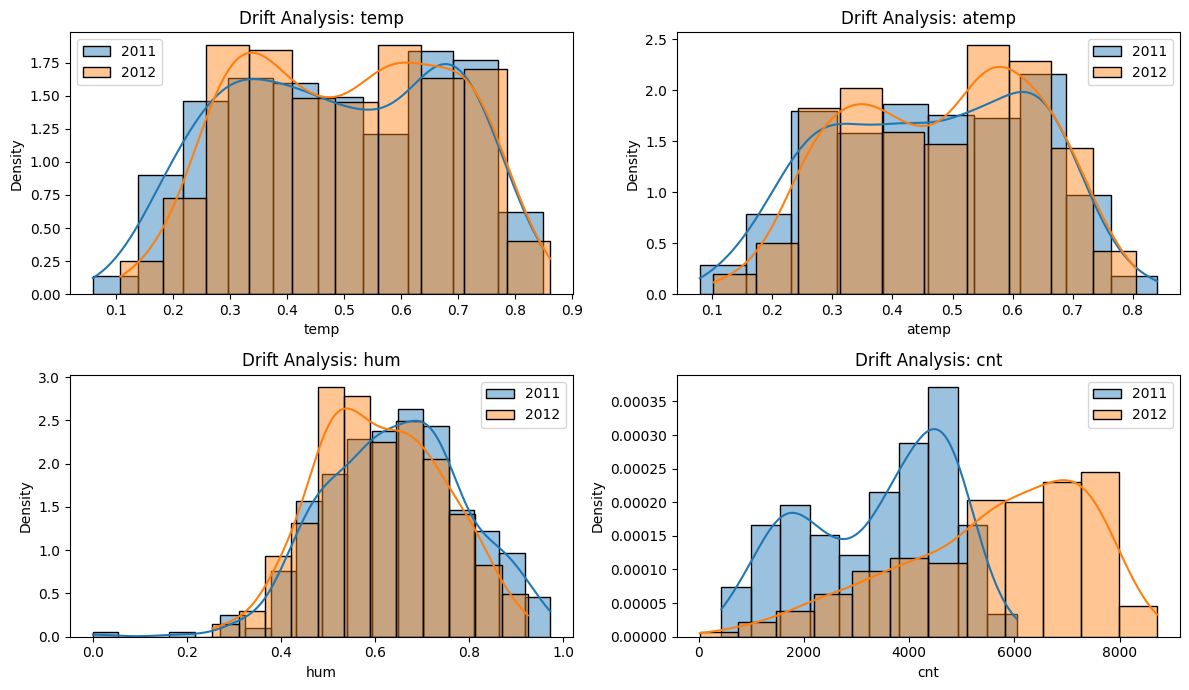

In [29]:
features_to_plot = ["temp", "atemp", "hum", "cnt"]

blue = "#1f77b4"    
orange = "#ff7f0e"  

plt.figure(figsize=(12, 7))

for i, col in enumerate(features_to_plot):
    plt.subplot(2, 2, i + 1)

    sns.histplot(
        df_2011_processed[col],
        color=blue,
        label="2011",
        kde=True,
        stat="density",
        alpha=0.45,
        edgecolor="black"
    )

    sns.histplot(
        df_2012_processed[col],
        color=orange,
        label="2012",
        kde=True,
        stat="density",
        alpha=0.45,
        edgecolor="black"
    )

    plt.title(f"Drift Analysis: {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# Show which drifted features are important
print("="*80)
print("LINKING DRIFT TO DEGRADATION")
print("="*80)

# Get top 5 important features
feature_importance = pd.DataFrame({
    'feature': X_train_2011.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features in Model:")
print(feature_importance.head(10).to_string(index=False))

# Features that drifted
drifted = ['temp', 'atemp', 'holiday', 'hum', 'weathersit']

print(f"\nFeatures that drifted: {drifted}")


LINKING DRIFT TO DEGRADATION


NameError: name 'model' is not defined

In [ ]:
df_2012_processed_ohe = pd.get_dummies(df_2012_processed, columns=['season', 'weathersit', 'weekday', 'mnth'], drop_first=True, dtype=int)

df_2012_processed_ohe.head()

### Prepares Features and Target

In [ ]:
# separate features and target
X = df_2012_processed_ohe.drop('cnt', axis=1)
y = df_2012_processed_ohe['cnt']

In [ ]:
# Train-test split
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_2012.shape, X_test_2012.shape

In [ ]:
final_model_name = "bike_demand_model"
alias_name = "best_model" 

model_uri = f"models:/{final_model_name}@{alias_name}"
model = mlflow.sklearn.load_model(model_uri)

print("Loaded model:", model_uri)

In [ ]:
# 2011 TEST performance
pred_2011 = model.predict(X_test_2011)
rmse_2011 = np.sqrt(mean_squared_error(y_test_2011, pred_2011))
mae_2011  = mean_absolute_error(y_test_2011, pred_2011)
r2_2011   = r2_score(y_test_2011, pred_2011)

# 2012 TEST performance (drifted)
pred_2012 = model.predict(X_test_2012)
rmse_2012 = np.sqrt(mean_squared_error(y_test_2012, pred_2012))
mae_2012  = mean_absolute_error(y_test_2012, pred_2012)
r2_2012   = r2_score(y_test_2012, pred_2012)

print("\n" + "="*70)
print("IMPACT OF DRIFT ON MODEL PERFORMANCE (TEST SETS)")
print("="*70)
print(f"2011 Test -> RMSE: {rmse_2011:.3f} | MAE: {mae_2011:.3f} | R2: {r2_2011:.3f}")
print(f"2012 Test -> RMSE: {rmse_2012:.3f} | MAE: {mae_2012:.3f} | R2: {r2_2012:.3f}")

print(f"\nRMSE change: {((rmse_2012-rmse_2011)/rmse_2011)*100:.2f}%")
print(f"MAE change : {((mae_2012-mae_2011)/mae_2011)*100:.2f}%")

### Operational Recommendation

**Recommended Action: Retrain the model immediately using 2012 data**

The analysis reveals severe model degradation with RMSE increasing by 309.65% (from 531.074 to 2175.554) and a negative R^2 of -0.442, indicating the model performs worse than a simple mean baseline. This catastrophic failure is attributed to significant drift in critical predictive features: the two most important features—atemp (40.3% importance) and temp (29.6% importance)—both drifted by approximately 3%, while humidity (-4.89%) and weather conditions (-3.73%) also shifted substantially. Since these weather-related features account for nearly 70% of the model's predictive power and all experienced notable distribution changes between 2011 and 2012, the model's learned patterns from 2011 are no longer valid for 2012 data. Given the magnitude of degradation (>10% threshold) and the business impact of completely unreliable bike demand predictions—leading to potential shortages or resource wastage—immediate retraining is essential. Following retraining, we recommend implementing monthly model updates, automated drift monitoring using tools like Evidently AI, and establishing performance alerts triggered when RMSE degradation exceeds 10% to prevent similar failures in the future.

### Operational Recommendation

**Recommended Action: Retrain the model immediately using 2012 data**

The model shows severe performance degradation with RMSE increasing by 309.65% and R2 becoming negative (-0.442), meaning predictions are worse than a simple average. This significant failure stems from substantial drift in the model's most critical features: temperature (atemp and temp) which together account for 70% of the model's importance both drifted by ~3%, while humidity and weather conditions also shifted by 4-5%. Since the model learned weather patterns from 2011 that no longer apply to 2012, predictions are completely unreliable, risking poor bike allocation and customer dissatisfaction. Immediate retraining with 2012 data is required, followed by implementation of monthly retraining schedules and automated drift monitoring to prevent future degradation.